# Datasets Processing Notebook

**Processing and Visualizing Animals10 dataset for Task 5**

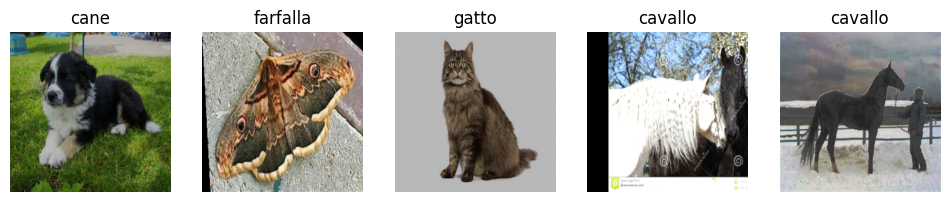

In [4]:
import os
from PIL import Image
import torch
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 

IMAGE_SIZE = 224

TRAIN_TFMS = transforms.Compose([
    transforms.RandAugment(),
    transforms.Resize((256, 256)),
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
])

TEST_TFMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
])

class Animal10Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for img_file in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, FileNotFoundError):
            print(f"Skipping invalid image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.image_paths)) 

        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

def get_dataloader(root_dir, batch_size=32, num_workers=1):
    train_dataset = Animal10Dataset(os.path.join(root_dir, 'raw-img'), transform=TRAIN_TFMS)
    test_dataset = Animal10Dataset(os.path.join(root_dir, 'raw-img'), transform=TEST_TFMS)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


root_dir = '/kaggle/input/animals10'
train_loader, test_loader = get_dataloader(root_dir=root_dir)


def show_images(loader):

    images, labels = next(iter(loader))
    images = images.permute(0, 2, 3, 1)  #Change from (B, C, H, W) to (B, H, W, C)
    images = images.numpy()  # Convert to numpy array

    plt.figure(figsize=(12, 12))
    for i in range(min(5, len(images))):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

show_images(train_loader)


In [5]:
# !pip install torch torchvision matplotlib


**Test Stylization Code on Animals10 - VGG**

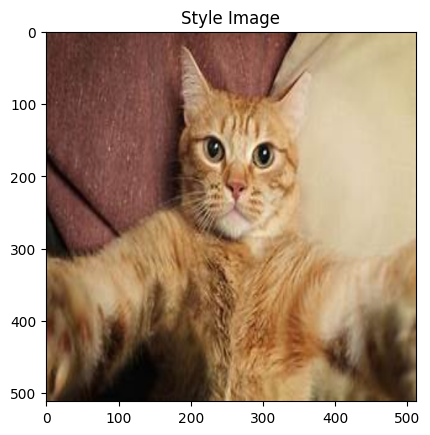

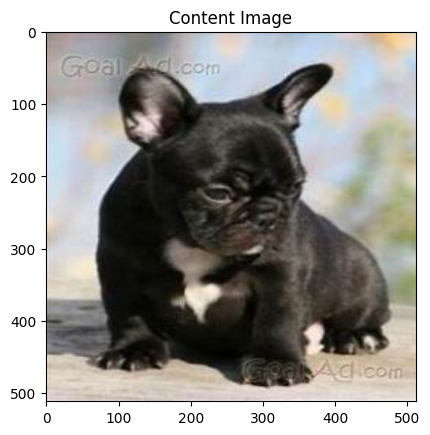

run 50:
Style Loss: 0.000004 Content Loss: 2.133107
run 100:
Style Loss: 0.000001 Content Loss: 1.788919
run 150:
Style Loss: 0.000000 Content Loss: 1.374985
run 200:
Style Loss: 0.000000 Content Loss: 1.060457
run 250:
Style Loss: 0.000000 Content Loss: 0.840540
run 300:
Style Loss: 0.000000 Content Loss: 0.678544


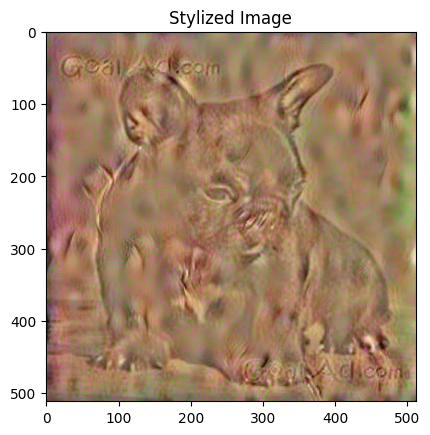

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  
    transforms.ToTensor()
])

def image_loader(image_name):
    """Load and transform an image."""
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)  
    return image.to(device, torch.float)

style_img = image_loader("/kaggle/input/animals10/raw-img/gatto/1.jpeg")
content_img = image_loader("/kaggle/input/animals10/raw-img/cane/OIP--1QXriWyOTJg-9fEwbznmgHaI4.jpeg")

assert style_img.size() == content_img.size(), "Style and content images must be the same size"

unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    """Display an image from a tensor."""
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title="Style Image")

plt.figure()
imshow(content_img, title="Content Image")

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size() 
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t()) 
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

content_losses = []
style_losses = []
model = nn.Sequential()

i = 0  
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f'conv_{i}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu_{i}'
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = f'pool_{i}'
    elif isinstance(layer, nn.BatchNorm2d):
        name = f'bn_{i}'

    model.add_module(name, layer)

    # Add content loss after the chosen content layer
    if name in content_layers:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module(f"content_loss_{i}", content_loss)
        content_losses.append(content_loss)

    # Add style loss after the chosen style layers
    if name in style_layers:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module(f"style_loss_{i}", style_loss)
        style_losses.append(style_loss)

for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break

model = model[:(i + 1)]

input_img = torch.randn(content_img.data.size(), device=device)

mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)
normalization = transforms.Normalize(mean, std)
optimizer = optim.LBFGS([input_img.requires_grad_()])

run = [0]
max_iter = 300

# Adjusting style weight and content weight
style_weight = 1e6  # Larger weight for style
content_weight = 0.91e-1  # Smaller weight for content

while run[0] <= max_iter:
    def closure():
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        loss = style_score * style_weight + content_score * content_weight
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"run {run[0]}:")
            print(f'Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f}')

        return style_score + content_score

    optimizer.step(closure)


input_img.data.clamp_(0, 1)


plt.figure()
imshow(input_img, title='Stylized Image')
plt.show()


**Small Base Animals Dataset for image processing**

In [1]:
import os
import shutil
import random
import zipfile

input_dir = "/kaggle/input/animals10/raw-img"
output_dir = "/kaggle/working/small_animal_dataset"
zip_file = "/kaggle/working/small_animal_dataset.zip"


if not os.path.exists(output_dir):
    os.makedirs(output_dir)


num_images_per_class = 200


def select_images(input_dir, output_dir, num_images):
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            selected_images = random.sample(images, min(len(images), num_images))
            
            class_output_dir = os.path.join(output_dir, class_folder)
            if not os.path.exists(class_output_dir):
                os.makedirs(class_output_dir)

            for img_name in selected_images:
                src_path = os.path.join(class_path, img_name)
                dst_path = os.path.join(class_output_dir, img_name)
                shutil.copy(src_path, dst_path)


select_images(input_dir, output_dir, num_images_per_class)

with zipfile.ZipFile(zip_file, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_dir))

print(f"Dataset compressed into: {zip_file}")


Dataset compressed into: /kaggle/working/small_animal_dataset.zip


**Extracting 50 images from manually filtered small Animals10 dataset**

In [ ]:
import os
import random
import shutil


input_dir = '/kaggle/input/animals10-filtered/small_animal_dataset_updated'
output_dir = '/kaggle/working/small_filtered_contentdataset'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num_images = 50
valid_extensions = ('.jpg', '.jpeg', '.png')

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]
        selected_images = random.sample(images, min(num_images, len(images)))

        new_class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(new_class_dir):
            os.makedirs(new_class_dir)
        
        for image in selected_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(new_class_dir, image)
            shutil.copyfile(src_path, dst_path)

print("New dataset created with 50 images per class.")

shutil.make_archive('/kaggle/working/small_filtered_contentdataset', 'zip', output_dir)

print("Dataset zipped and ready for download.")


**Stylizing Animals10 on 500 images** - Texture Bias

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import random
from tqdm import tqdm
import shutil
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_model_and_losses(cnn, style_img, content_img):
    model = nn.Sequential()
    content_losses = []
    style_losses = []
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

def run_style_transfer(cnn, content_img, style_img, max_iter=300, style_weight=1e4, content_weight=0.04):
    input_img = content_img.clone()
    model, style_losses, content_losses = get_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= max_iter:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            
            loss = style_score * style_weight + content_score * content_weight
            loss.backward()
            
            run[0] += 1
            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

def get_image_files(directory):
    return [str(p) for p in Path(directory).rglob("*") if p.suffix.lower() in ('.jpg', '.jpeg', '.png')]

def process_class(content_class_dir, style_images, output_base_dir):
    class_name = Path(content_class_dir).name
    output_dir = Path(output_base_dir) / class_name
    output_dir.mkdir(parents=True, exist_ok=True)
    
    content_images = get_image_files(content_class_dir)

    different_style_images = [img for img in style_images 
                             if Path(img).parent.name != class_name]
    
    if not different_style_images:
        print(f"No different style images available for class {class_name}")
        return
    
    print(f"Processing class: {class_name}")
    progress_bar = tqdm(total=len(content_images), desc=f"Styling {class_name}", unit="image")
    
    for content_path in content_images:
        style_path = random.choice(different_style_images)
        content_img = image_loader(content_path)
        style_img = image_loader(style_path)
        
        output_img = run_style_transfer(cnn, content_img, style_img)
        output_path = output_dir / Path(content_path).name
        unloader = transforms.ToPILImage()
        image = output_img.cpu().clone().squeeze(0)
        unloader(image).save(str(output_path))
        
        progress_bar.update(1)
    
    progress_bar.close()
    
    zip_path = Path(output_base_dir) / f"{class_name}_stylized.zip"
    shutil.make_archive(str(zip_path.with_suffix('')), 'zip', str(output_dir))
    print(f"Created zip file for {class_name}: {zip_path}")

def main():
    style_dir = '/kaggle/input/style-filtered-dataset'
    content_dir = '/kaggle/input/content-dataset/small_filtered_contentdataset'
    output_base_dir = '/kaggle/working/stylized_images'
    
    style_images = get_image_files(style_dir)
    
    for content_class_dir in Path(content_dir).iterdir():
        if content_class_dir.is_dir():
            process_class(str(content_class_dir), style_images, output_base_dir)

if __name__ == "__main__":
    main()


Processing class: cavallo



Styling cavallo: 100%|██████████| 50/50 [12:20<00:00, 14.81s/image]


Created zip file for cavallo: /kaggle/working/stylized_images/cavallo_stylized.zip
Processing class: pecora



Styling pecora: 100%|██████████| 50/50 [12:20<00:00, 14.81s/image]


Created zip file for pecora: /kaggle/working/stylized_images/pecora_stylized.zip
Processing class: elefante



Styling elefante: 100%|██████████| 50/50 [12:18<00:00, 14.78s/image]


Created zip file for elefante: /kaggle/working/stylized_images/elefante_stylized.zip
Processing class: gatto



Styling gatto: 100%|██████████| 50/50 [12:20<00:00, 14.81s/image]


Created zip file for gatto: /kaggle/working/stylized_images/gatto_stylized.zip
Processing class: scoiattolo



Styling scoiattolo: 100%|██████████| 50/50 [12:14<00:00, 14.69s/image]


Created zip file for scoiattolo: /kaggle/working/stylized_images/scoiattolo_stylized.zip
Processing class: gallina



Styling gallina: 100%|██████████| 50/50 [12:23<00:00, 14.87s/image]


Created zip file for gallina: /kaggle/working/stylized_images/gallina_stylized.zip
Processing class: ragno



Styling ragno: 100%|██████████| 50/50 [12:20<00:00, 14.81s/image]


Created zip file for ragno: /kaggle/working/stylized_images/ragno_stylized.zip
Processing class: mucca



Styling mucca: 100%|██████████| 50/50 [12:21<00:00, 14.82s/image]


Created zip file for mucca: /kaggle/working/stylized_images/mucca_stylized.zip
Processing class: cane



Styling cane: 100%|██████████| 50/50 [12:22<00:00, 14.84s/image]


Created zip file for cane: /kaggle/working/stylized_images/cane_stylized.zip
Processing class: farfalla



Styling farfalla: 100%|██████████| 50/50 [12:21<00:00, 14.83s/image]

Created zip file for farfalla: /kaggle/working/stylized_images/farfalla_stylized.zip


**Grey-Scale Animal10** - Color Bias

In [ ]:
import os
import zipfile
from PIL import Image

def convert_images_to_grayscale_and_zip(input_dir, output_zip_path):
    """Convert images in the input directory to grayscale and save them in a zip file."""
    temp_dir = 'grayscale_temp'
    os.makedirs(temp_dir, exist_ok=True)

    for root, _, files in os.walk(input_dir):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')): 
                img_path = os.path.join(root, filename) 
                img = Image.open(img_path).convert('L')  
                
                relative_path = os.path.relpath(img_path, input_dir)
                output_path = os.path.join(temp_dir, relative_path)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                img.save(output_path)  
                print(f'Converted {filename} to grayscale and saved in {output_path}.')

    with zipfile.ZipFile(output_zip_path, 'w') as zipf:
        for root, _, files in os.walk(temp_dir):
            for filename in files:
                file_path = os.path.join(root, filename)
                # Create a relative path for zipping
                arcname = os.path.relpath(file_path, temp_dir)
                zipf.write(file_path, arcname=arcname)  
                print(f'Added {arcname} to zip.')

    for root, _, files in os.walk(temp_dir):
        for filename in files:
            os.remove(os.path.join(root, filename))
    os.rmdir(temp_dir)  

input_directory = '/kaggle/input/contentdataset/small_filtered_contentdataset'
output_zip_path = '/kaggle/working/grayscale_images.zip'

convert_images_to_grayscale_and_zip(input_directory, output_zip_path)


**Noise Cifar Subset**

In [3]:
import os
import numpy as np
import cv2
import zipfile
import glob
import random
from PIL import Image
from tqdm import tqdm

base_path = '/kaggle/input/cifarbase-dataset/original_images'
classes = os.listdir(base_path)  

noisy_images_dir = '/kaggle/working/noisy_images'
os.makedirs(noisy_images_dir, exist_ok=True)
patch_size = (12, 12)
np.random.seed(42)
noise_patch = np.random.normal(0, 25, patch_size + (3,)).astype(np.uint8) 

x_start = random.randint(0, 32 - patch_size[1])
y_start = random.randint(0, 32 - patch_size[0])

def add_localized_noise(image):

    noisy_image = image.copy()
    noisy_image[y_start:y_start + patch_size[0], x_start:x_start + patch_size[1]] = noise_patch
    
    return noisy_image

for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    image_files = glob.glob(os.path.join(class_path, '*.*'))  
    
    class_noisy_dir = os.path.join(noisy_images_dir, class_name)
    os.makedirs(class_noisy_dir, exist_ok=True)
    
    for image_file in tqdm(image_files, desc=f'Processing {class_name}'):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        noisy_image = add_localized_noise(image)
        
        noisy_image_pil = Image.fromarray(noisy_image)
        noisy_image_name = os.path.join(class_noisy_dir, os.path.basename(image_file))
        noisy_image_pil.save(noisy_image_name)

zip_file_path = '/kaggle/working/noisy_images.zip'
with zipfile.ZipFile(zip_file_path, 'w') as zip_file:
    for root, _, files in os.walk(noisy_images_dir):
        for file in files:
            zip_file.write(os.path.join(root, file), arcname=os.path.relpath(os.path.join(root, file), noisy_images_dir))

print(f'Noisy images saved and zipped at: {zip_file_path}')


Processing deer: 100%|██████████| 50/50 [00:00<00:00, 735.09it/s]


Noisy images saved and zipped at: /kaggle/working/noisy_images.zip


**Global Style Cifar**

In [14]:
import os
import random
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import vgg19, VGG19_Weights
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Load the pre-trained VGG19 model
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_model_and_losses(cnn, style_img, content_img):
    model = nn.Sequential()
    content_losses = []
    style_losses = []
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

def run_style_transfer(cnn, content_img, style_img, max_iter=300, style_weight=1e6, content_weight=0.1):
    input_img = content_img.clone()
    model, style_losses, content_losses = get_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    plt.ion()  
    while run[0] <= max_iter:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            
            loss = style_score * style_weight + content_score * content_weight
            loss.backward()
            
            run[0] += 1

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    plt.ioff()  
    plt.show() 
    return input_img

def imshow(tensor):
    image = tensor.cpu().clone().detach() 
    image = image.squeeze(0)  
    image = transforms.ToPILImage()(image) 
    return image

def get_image_files(directory):
    return [str(p) for p in Path(directory).rglob("*") if p.suffix.lower() in ('.jpg', '.jpeg', '.png')]

def process_class(content_class_dir, style_img, output_base_dir):
    class_name = Path(content_class_dir).name
    output_dir = Path(output_base_dir) / class_name
    output_dir.mkdir(parents=True, exist_ok=True)
    content_images = get_image_files(content_class_dir)
    
    if len(content_images) > 50:
        content_images = random.sample(content_images, 50)
    
    progress_bar = tqdm(total=len(content_images), desc=f"Styling {class_name}", unit="image")
    
    for content_path in content_images:
        content_img = image_loader(content_path)
        style_img_tensor = image_loader(style_img)
        
        output_img = run_style_transfer(cnn, content_img, style_img_tensor)
        
        output_path = output_dir / Path(content_path).name
        unloader = transforms.ToPILImage()
        image = output_img.cpu().clone().squeeze(0)
        unloader(image).save(str(output_path))
        progress_bar.update(1)
    
    progress_bar.close()
    
    zip_path = Path(output_base_dir) / f"{class_name}_stylized.zip"
    shutil.make_archive(str(zip_path.with_suffix('')), 'zip', str(output_dir))
    print(f"Created zip file for {class_name}: {zip_path}")



def main():
    style_image_path = '/kaggle/input/animals10-filtered/small_animal_dataset_updated/farfalla/OIP-5Alx0UwU7y88i4eHFN5RBwHaGF.jpeg'  # Path to the style image
    content_dir = '/kaggle/input/cifar10/cifar10/test/'  
    output_base_dir = '/kaggle/working/stylized_images'  
    
    for class_name in ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']:
        class_path = os.path.join(content_dir, class_name)
        process_class(class_path, style_image_path, output_base_dir)

if __name__ == "__main__":
    main()


Styling airplane: 100%|██████████| 50/50 [12:47<00:00, 15.35s/image]


Created zip file for airplane: /kaggle/working/stylized_images/airplane_stylized.zip


Styling automobile: 100%|██████████| 50/50 [12:46<00:00, 15.34s/image]


Created zip file for automobile: /kaggle/working/stylized_images/automobile_stylized.zip


Styling bird: 100%|██████████| 50/50 [12:48<00:00, 15.36s/image]


Created zip file for bird: /kaggle/working/stylized_images/bird_stylized.zip


Styling cat: 100%|██████████| 50/50 [12:47<00:00, 15.35s/image]


Created zip file for cat: /kaggle/working/stylized_images/cat_stylized.zip


Styling deer: 100%|██████████| 50/50 [12:47<00:00, 15.34s/image]


Created zip file for deer: /kaggle/working/stylized_images/deer_stylized.zip


Styling dog: 100%|██████████| 50/50 [12:44<00:00, 15.29s/image]


Created zip file for dog: /kaggle/working/stylized_images/dog_stylized.zip


Styling frog: 100%|██████████| 50/50 [12:42<00:00, 15.26s/image]


Created zip file for frog: /kaggle/working/stylized_images/frog_stylized.zip


Styling horse: 100%|██████████| 50/50 [12:48<00:00, 15.37s/image]


Created zip file for horse: /kaggle/working/stylized_images/horse_stylized.zip


Styling ship: 100%|██████████| 50/50 [12:47<00:00, 15.35s/image]


Created zip file for ship: /kaggle/working/stylized_images/ship_stylized.zip


Styling truck: 100%|██████████| 50/50 [12:46<00:00, 15.34s/image]


Created zip file for truck: /kaggle/working/stylized_images/truck_stylized.zip
